# ECON 8185 - HW 2

João Lazzaro - santo279@umn.edu

The model is:

$$\max_{c_t,x_t,l_t} E \sum_{t=0}^\infty \beta^t \frac{\left(c_tl_t^\psi\right)^{1-\sigma}}{1-\sigma} N_t$$
S.T. 
$$ c_t +(1+\tau_{xt})x_t =r_t k_t +(1-\tau_{ht})w_t h_t + T_t$$
$$ N_{t+1} k_{t+1} = [(1-\delta)k_t+x_t]N_t$$
$$h_t+l_t =1$$
$$S_t = P S_{t-1}+Q\epsilon_t,\;\;S_t = [\ln z_t,\tau_{ht},\tau_{xt}, \ln g_t]$$
$$ c_t,x_t\geq0$$

Where $N_t = (1+\gamma_n)^t$ and firm tecnhology is $Y_t = K_t^\theta (Z_t L_t)^{1-\theta}$. $\gamma_z$ is the rate of labor-augmenting technical progress. The stochastic shocks hitting this economy affect technology, tax rates, and government spending and the stochastic processes are modeled as a VAR(1) process. The resource constraint is $Y_t=N_t(c_t +x_t +g_t)$. We must work with detrended variables, we should use "hat" variables, but typing this is time consuming so from now on all variables should be understood as detrended unless I say something about them.

Defining some parameters:

In [165]:
using Plots, NLsolve, ForwardDiff, DataFrames, LinearAlgebra, QuantEcon, Plots, Optim, Statistics
#Parameters:
δ = 0.0464   #depreciation rate
θ = 0.35  #capital share of output
β = 0.9722  #Discouting
σ = 1  #Elasticity of Intertemporal Substitution
ψ = 3    #Labor parameter
γn= 0.015    #Population growth rate
γz= 0.016   #Productivitu growth rate
gss = 0.01 #average g
τxss = 0.05 #average τx
τhss = 0.05 #average τh
zss = 0.0 #average z (z is in logs)


#Parameters to be estimated in the next homework
#Autocorrelations
ρg = 0.9
ρx = 0.1
ρh = 0.1
ρz = 0.9

# Cross-correlations
ρzg= 0.0
ρzx = 0.0
ρzh = 0.0
ρhz = 0.0
ρhx = 0.0
ρhg = 0.0
ρxz = 0.0
ρxh = 0.0
ρxg = 0.0
ρgz = 0.0
ρgx = 0.0
ρgh = 0.0

#Variances
σg= 0.001
σx = 0.001
σz = 0.01
σh = 0.01
#Covariances
σzg= 0.0
σzx = 0.00
σzh = 0.00
σhx = 0.00
σhg = 0.00
σxg = 0.00

0.0

The detrended FOC's of this model are:

$$c_t+(1+\gamma_z)(1+\gamma_n)k_{t+1} - (1-\delta)k_t+g_t = y_t =k_t^\theta(z_th_t)^{1-\theta}$$
$$\psi \frac{c_t}{1-h_t} = (1-\tau_{ht})(1-\theta)\left(\frac{k_t}{h_t}\right)^\theta z_t^{1-\theta}$$
$$c_t^{-\sigma}(1-h_t)^{\psi(1-\sigma)} (1+\tau_{xt})=\beta(1+\gamma_z)^{-\sigma}E_t c_{t+1}^{-\sigma} (1- h_{t+1})^{\psi(1-\sigma)}\left(\theta k_{t+1}^{\theta}(z_{t+1} h_{t+1})^{1-\theta} + (1-\delta)(1+\theta_{xt+1})\right)$$

Substituting for $c$, we get an equation for $k$, and one for $h$. Below, I find the Steady State values:


In [166]:
#Function with the FOCs
zss = exp(zss)

function SS!(eq,vector::Vector)
    k,h, c= vector
    eq[1]=k/h-((1+τxss)*(1-β*(1+γz)^(-σ)*(1-δ))/(β*(1+γz)^(-σ)*θ*zss^(1-θ)) )^(1/(θ-1))
    eq[2]=c-( (k/h)^(θ-1)*zss^(1-θ) -(1+γz)*(1+γn)+1-δ)*k+gss
    eq[3]=ψ*c-( (1-τhss)*(1-θ)*(k/h)^θ *zss^(1-θ))*(1-h)
end

SteadyState = nlsolve(SS!, [3,0.25,.4],ftol = :1.0e-20)
kss,hss,css = SteadyState.zero

3-element Array{Float64,1}:
 1.6707265229440968 
 0.22844261316599446
 0.31866093597940304

In [167]:
    #GDP
    yss = kss^(θ)*(zss*hss)^(1-θ)
    xss = (1+γz)*(1+γn)*kss-(1-δ)*kss

0.12971520724137942

## Question 1

### a) Iterate on Bellman’s equation

Due to the curse of dimensionality, I won't pursue this path.

### b) Map it to a linear quadratic problem

Recall from lecture notes, we have to map the original problem into the following LQ problem:

$$ \max_{\{{u_t}\}_{t=0}^\infty} E_0 \sum_{t=0}^\infty \beta^t (X'_tQX_t+u'_tRu_t+2X'_tWu_t) $$

s.t.
$$ X_{t+1} = A X_t + B u_t + C \epsilon_{t+1}$$
$X_0$ given.



In this case, we have: $u_t = [k_{t+1},h_t]'$

Note that in this problem ${X}_t$ may be decomposed as:

$$X_t = \begin{bmatrix}
    {X}_1     \\
    {X}_2 \\ 
    {X}_3
\end{bmatrix}_t$$

Where ${X}_1$ are the individual states, ${X}_2$ are the aggregate or exogenous states with known laws of motion, and ${X}_3$ are the aggregate states with laws of motion that are unknown and need to be computed in equilibrium. We have that:

${X}_1 = [1,k_t]'$, ${X}_2 = [\tau_{xt},\tau_{ht},g_t]$ and ${X}_3 = [K_t,H_t]$

Finally, rewrite $y_t = [\tilde{X}_1,\tilde{X}_2]'$ and the problem constraint becomes:

$$ y_{t+1} = \tilde{A}_y y_t + \tilde{B}_y \tilde{u}_t + A_z \tilde{X}_{3t}$$

Where tilde variables are the undiscounted counterpart of each variable. Matrices $A_y, B_y, Q, R$ and $W$ may be found by second and first order Taylor expansions of the utility function and constraints. Matrix $A_z$ is for now unknown. Following the methods in the lecture notes (using Big K, little k trick) this problem may be solved. We mapped it to a LQ problem and we solve it using the modified Vaughan's method in the next section: 


### c) Apply Vaughan’s method.

I use the modified Vaughan method using the log linearized FOC's as in the lecture notes.

Log-linearizing the FOC equations we get the following system of equations:


$$ 0 = E_t[a_1\tilde{k}_t +a_2\tilde{k}_{t+1}+a_3\tilde{h}_t+a_4 \tilde{z}_t + a_5 \tilde{\tau}_{ht} +a_6 \tilde{g}_t] $$
$$ 0 = E_t[b_1\tilde{k}_t +b_2\tilde{k}_{t+1}+b_3\tilde{k}_{t+2}+b_4 \tilde{h}_t + b_5 \tilde{h}_{t+1} b_6 \tilde{z}_t +b_7 \tilde{\tau}_{xt} +b_8 \tilde{g}_t + b_9 \tilde{z}_{t+1} +b_{10} \tau_{xt+1}+b_{11}\tilde{g}_{t+1}]  $$

Where tilde variables are log deviations from Steady State. Stacking up the equations we get:
$$0 = E_t \begin{bmatrix}
    1       & 0 & 0  \\
    0       & 0 & 0  \\
    0       & b_3 & b_5 
\end{bmatrix}
\begin{bmatrix}
    \tilde{k}_{t+1}\\
    \tilde{k}_{t+2}\\
    \tilde{h}_{t+1}        
\end{bmatrix} + \begin{bmatrix}
    0       & -1 & 0  \\
    a_1       & a_2 & a_3  \\
    b_1       & b_2 & b_4 
\end{bmatrix}
\begin{bmatrix}
    \tilde{k}_{t}\\
    \tilde{k}_{t+1}\\
    \tilde{h}_{t}        
\end{bmatrix} + \begin{bmatrix}
    0       & 0 & 0 & 0 & 0 & 0 & 0 & 0  \\
    a_4       & a_5 & 0 & a_6 &0&0&0&0  \\
    b_6       & 0 & b_7 & b_8 & b_9 & 0 &b_{10} & b_{11} 
\end{bmatrix}\begin{bmatrix}
    S_t\\
    S_{t+1}        
\end{bmatrix}$$
We call the first matrix $A_1$, and the second $A_2$. The code below log-linearizes and find these matrices:

In [168]:

function loglineq1(vector::Vector)
    k,k1,h,z,τh,g= vector

    c = k * ((z *h)^(1-θ))^(1/θ) - ((1+γz)*(1+γn)*k1-(1-δ)*k+ g )^(1/θ)
    eq =(ψ *c)^(1/θ)  - (k/h)*((1-h)*(1-τh)*(1-θ)*z^(1-θ))^(1/θ)

    return eq
end
function loglineq2(vector::Vector)
    k,k1,k2,h,h1,z,τx,g,z1,τx1,g1 = (vector)
    c = k * ((z *h)^(1-θ))^(1/θ) - ((1+γz)*(1+γn)*k1-(1-δ)*k+ g )^(1/θ)
    c1 = k * ((z1 *h1)^(1-θ))^(1/θ) - ((1+γz)*(1+γn)*k2-(1-δ)*k1+ g1 )^(1/θ)
    eq =  (c^(-σ) *(1-h)^(ψ*(1-σ))*(1+τx)  - (1-δ)*(1+τx1)* β*(1+γz)^(-σ) * c1^(-σ) * (1-h1)^(ψ*(1-σ)))^(-1/θ) -
     (β*(1+γz)^(-σ) * c1^(-σ) * (1-h1)^(ψ*(1-σ)) * θ*(z1*h1)^(1-θ))^(-1/θ)* k1
    return eq
end


#log deviations
T=ForwardDiff.gradient(loglineq1,[kss,kss,hss,zss,τhss,gss])
a =[-kss*T[1]/(kss*T[1]),-kss*T[2]/(kss*T[1]),-hss*T[3]/(kss*T[1]),
-zss*T[4]/(kss*T[1]),-τhss*T[5]/(kss*T[1]),-gss*T[6]/(kss*T[1])]
#if ψ==0
#    a[1],a[2:end]=-1,zeros(5)
#end

T=ForwardDiff.gradient(loglineq2,[kss,kss,kss,hss,hss,zss,τxss,gss,zss,τxss,gss])
b = [kss*T[1]/(-kss*T[1]),kss*T[2]/(-kss*T[1]),kss*T[3]/(-kss*T[1]),hss*T[4]/(-kss*T[1]),
hss*T[5]/(-kss*T[1]),zss*T[6]/(-kss*T[1]),τxss*T[7]/(-kss*T[1]),gss*T[8]/(-kss*T[1]),
zss*T[9]/(-kss*T[1]),τxss*T[10]/(-kss*T[1]),gss*T[11]/(-kss*T[1])]

A1 = [1 0 0; 0 0 0; 0 b[3] b[5]]
A2 = [0 -1 0; a[1] a[2] a[3]; b[1] b[2] b[4]]
U = [0 0 0 0 0 0 0 0;
a[4] a[5] 0 a[6] 0 0 0 0;
b[6] 0 b[7] b[8] b[9] 0 b[10] b[11]]

A1,A2

([1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 -1.01871 1.56869], [0.0 -1.0 0.0; -1.0 -0.19108 2.77059; -1.0 2.01043 -1.65162])

We look for a solution of the form: $$\tilde{k}_{t+1} = A \tilde{k}_t +BS_t $$ $$ Z_t = C X_t + D S_t $$ $$S_t = P S_{t-1} + Q \epsilon_t$$
Where $Z_t = [\tilde{k}_{t+1},\tilde{h}_t]'$ and $S_t$ are the stochastic exogenous variables. We compute the generalized eigenvalues and eigenvectors for matrices $A_1$ and $−A_2$ because $A_1$ is not invertible. Thus, $A_2 V = -A_1 V \Pi$ and we can get $A$ and $C$ by:
$$A = V_{11} \Pi_{1,1} V_{1,1}^{-1}$$
 $$C = V_{2,1}V_{1,1}^{-1}$$

In [169]:
eig = eigen(A1,-A2)
V=eig.vectors
Π = eig.values
#Sorting
for j=1:3
for i=1:2
    if eps(Float64)<abs(Π[i+1])<abs(Π[i])
        Π[i],Π[i+1] = Π[i+1],Π[i]
        V[:,i],V[:,i+1] = V[:,i+1],V[:,i]
    elseif abs(Π[i]) < eps(Float64)
        Π[i],Π[end] =Π[end],Π[i]
        V[:,i],V[:,end]=V[:,end],V[:,i]
    end
end
end
if abs(Π[1])>1
    error("All Eigen Values outside unit circle")
end
Π= Diagonal(Π)

3×3 Diagonal{Float64,Array{Float64,1}}:
 0.614295   ⋅         ⋅         
  ⋅        0.928641   ⋅         
  ⋅         ⋅        1.25286e-16

In [170]:
A = V[1,1]*Π[1,1]*inv(V[1,1])
C = V[2:end,1]*(V[1,1])
C = hcat(C,zeros(2,1))

2×2 Array{Float64,2}:
 0.614295  0.0
 0.178568  0.0

In [171]:
P = [ρz ρzh ρzx ρzg;
ρhz ρh ρhx ρhg ;
ρxz ρxh ρx ρxg ;
ρgz ρgh ρgx ρg]
Q = [σz σzh σzx σzg;
σzh σh σhx σhg ;
σzx σhx σx σxg ;
σzg σhg σxg σg]

4×4 Array{Float64,2}:
 0.01  0.0   0.0    0.0  
 0.0   0.01  0.0    0.0  
 0.0   0.0   0.001  0.0  
 0.0   0.0   0.0    0.001

Finally, to get the matrices $B$ and $D$, we just need to solve a linear system of equations (see Ellen's notes):

In [178]:
function system!(eq,vector::Vector)
    #vector = rand(8)
    #eq= rand(8)
    B=vector[1:4]'
    D2 = vector[5:8]'

    eq[1:4] = a[2].*B .+ a[3].*D2 .+ [a[4] a[5] 0 a[6]]
    eq[5:8] = b[2].*B .+ b[3].*A.*B .+ b[3].*B*P .+ b[4].*D2 .+ b[5].*C[2].*B .+ b[5].*B*P.+
    [b[6] 0 b[7] b[8]].+[b[9] 0 b[10] b[11] ]*P
 return     eq
end

Sol = nlsolve(system!, ones(8),ftol = :1.0e-20, method = :trust_region , autoscale = true)
D=ones(2,4)
D[1,:]= Sol.zero[1:4]
D[2,:]= Sol.zero[5:8]
D

2×4 Array{Float64,2}:
 0.753975  -0.0747081  -0.0231612   -5.87648e-5
 0.840745  -0.0777903  -0.00159736   0.00039624

## Question 2

For this question I use the solution of question 1-c).

First, I will rewrite the model in the form: 
 $$ X_{t+1} = AX_t + B \varepsilon_{t+1}$$
$$Y_t = CX_t+\omega_t$$
Where, $X_t = [k_t,s_t],s_t=[z_t,\tau_{ht},\tau_{xt},g_t]$, $Y_t = [y_t,x_t,h_t]$ and as before:
$$s_{t+1} = P s_t +Q \varepsilon_{t+1}$$
We need to log linearize $y,x$ since we already done it for labor:

In [9]:

#Rewritting
A = hcat(vcat(C[1],zeros(4,1)),vcat(D[1,:]',P))
B = hcat(zeros(5,1),vcat(zeros(1,4),Q))


#We have h as function of states. To find the Matrix B, we need to find y and x
#as a function of states

function kt1(vector::Vector)
    k,z,τh,τx,g = vector
    tilde = log.([k,z,τh,τx,g]).-log.([kss,zss,τhss,τxss,gss])
    for i = 1:length(tilde)
        if isnan(tilde[i])
            tilde[i] = 0
        end
    end

    k1= A[1,:]' * tilde
    return k1
end


function ht(vector::Vector)
    k,z,τh,τx,g = vector
    tilde = log.([k,z,τh,τx,g]).-log.([kss,zss,τhss,τxss,gss])
    for i = 1:length(tilde)
        if isnan(tilde[i])
            tilde[i] = 0
        end
    end
    h = C[2,1]*(log(k)-log(kss)) + D[2,:]' * tilde[2:end]
    return h
end


ht (generic function with 1 method)

In [10]:
#log-linearizing y as a function of states
function yt(vector::Vector)
    k,z,τh,τx,g = vector
    h = exp(ht(vector)+log(hss))
    y = k^θ * (z*h)^(1-θ)
    return y
end

#GDP
yss = kss^(θ)*(zss*hss)^(1-θ)

T=ForwardDiff.gradient(yt,[kss,zss,τhss,τxss,gss])
ycoefs = [kss*T[1]/yss,zss*T[2]/yss,τhss*T[3]/yss,τxss*T[4]/yss,gss*T[5]/yss]



#log linearizing x as function of states
function xt(vector::Vector)
    k,z,τh,τx,g = vector
    k1 = exp(kt1(vector)+log(kss))
    x= (1+γn)*(1+γz)k1 - (1-δ)k

    return x
end
xss = (1+γz)*(1+γn)*kss-(1-δ)*kss
T=ForwardDiff.gradient(xt,[kss,zss,τhss,τxss,gss])
xcoefs = [kss*T[1]/xss,zss*T[2]/xss,τhss*T[3]/xss,τxss*T[4]/xss,gss*T[5]/xss]

#We have the matrix C!
C = [ycoefs[1] ycoefs[2] ycoefs[3] ycoefs[4] ycoefs[5];
xcoefs[1] xcoefs[2] xcoefs[3] xcoefs[4] xcoefs[5];
C[2,1] D[2,1] D[2,2] D[2,3] D[2,4];
0 0 0 0 1]


4×5 Array{Float64,2}:
  0.466069   1.19648   -0.0505637  -0.00103829   0.000257556
 -4.12306   10.0146    -0.992297   -0.307635    -0.000780533
  0.178568   0.840745  -0.0777903  -0.00159736   0.00039624 
  0.0        0.0        0.0         0.0          1.0        

Now, I simulate the variables with known law of motion:

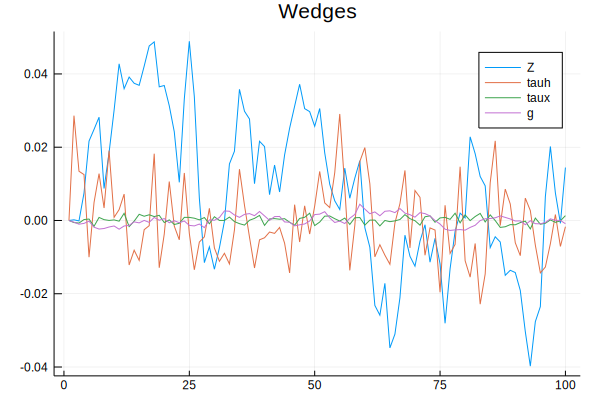

In [11]:
#defining the vectors
T=100
X= ones(5,T).* [0,0,0,0,0]
Y = ones(4,T).*[0,0,0,0]
S = randn(5,T)
for t=1:T

    if t>1
    X[:,t] = A*X[:,t-1]+ B*S[:,t]
    end
    Y[:,t] = C*X[:,t] 
end

plot([X[2,:],X[3,:],X[4,:],X[5,:]],title ="Wedges", labels = ["Z","tauh","taux","g"])

Below are the endogenous variables:

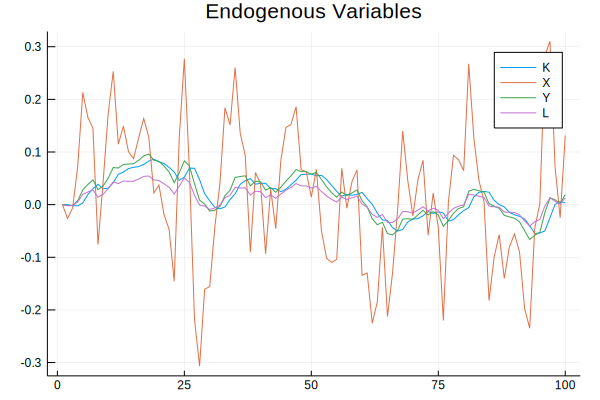

In [12]:
plot([X[1,:],Y[2,:],Y[1,:],Y[3,:]],title = "Endogenous Variables",labels = ["K","X","Y","L"])

In the code below, we calculate the factor prices (in log deviations):

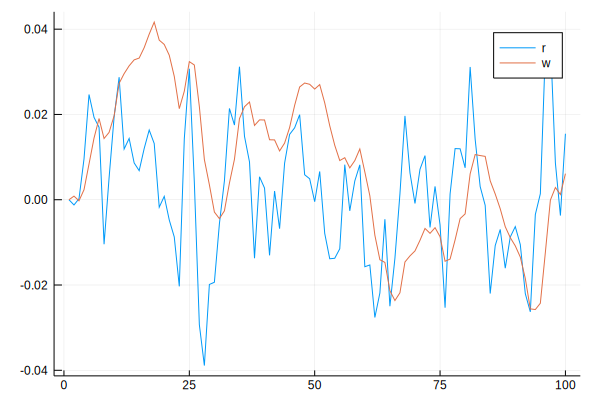

In [13]:
r = (θ-1) .* X[1,:] .+ (1-θ) .*(X[2,:] .+ Y[3,:])
w = θ.* X[1,:] .+ (1-θ) .* X[2,:] .- θ .* Y[3,:]
plot([r,w], labels = ["r","w"])

The code above is summarized in a function State_Space which returns the matrices A,B,C

In [15]:
include("State_Space.jl")

State_Space (generic function with 1 method)

In [16]:
Y


4×100 Array{Float64,2}:
 0.0  -0.00122713   -0.00175367   0.00726119   …   0.00216198    0.0190259  
 0.0  -0.0263883    -0.00616871   0.0720432       -0.0249459     0.13133    
 0.0  -0.00207148   -0.00150368   0.00491529       0.000944602   0.0129107  
 0.0  -0.000469327  -0.00101432  -0.000797042      1.71795e-5   -0.000878856

In [17]:
X


5×100 Array{Float64,2}:
 0.0   0.0          -0.00198672   -0.00230158   …   0.00587058    0.00355046 
 0.0   0.000183589  -0.0001245     0.00749509      -0.000779558   0.0144482  
 0.0   0.0286225     0.013433      0.012527        -0.00709025   -0.00169595 
 0.0  -0.00056819   -0.000700526   0.000248698     -9.78484e-5    0.00132198 
 0.0  -0.000469327  -0.00101432   -0.000797042      1.71795e-5   -0.000878856

In [18]:
C


4×5 Array{Float64,2}:
  0.466069   1.19648   -0.0505637  -0.00103829   0.000257556
 -4.12306   10.0146    -0.992297   -0.307635    -0.000780533
  0.178568   0.840745  -0.0777903  -0.00159736   0.00039624 
  0.0        0.0        0.0         0.0          1.0        